# 数独ソルバー

本章では、数独ソルバーを例にして、充足可能性問題について説明します。

## 充足可能性問題

充足可能性は、与えられたブール方程式を解き、問題を満たす変数の割り当てを見つけるために使用されます。ブール充足可能性問題（以下、SAT）は決定問題に属し、最初にNP完全であることが証明された問題です。これは、計算機科学の基礎理論、アルゴリズム、人工知能、ハードウェア設計など、多くの分野で重要な問題です。本章では、`pysat` を使用して数独ゲームを解く方法を紹介します。

まず、例を通じてブール方程式とは何かを説明し、それをSATソルバーが必要とする**合取標準形（CNF）** に変換する方法、そして `pysat` を用いた解法を紹介します。

> **論理推理問題**
>
> 4人の容疑者が以下のように供述しました：
>
> - 甲：「私が犯人ではない」
> - 乙：「丁が犯人だ」
> - 丙：「乙が犯人だ」
> - 丁：「乙は私を陥れようとしている」
>
> 4人のうち、真実を話しているのは1人だけである。犯人を推理せよ。

4人の容疑者甲（A）、乙（B）、丙（C）、丁（D）について、それぞれが犯人であるかどうかをブール変数で表します。  
例えば、**A** は「甲が犯人であること」を意味し、**~A** は「甲が犯人ではないこと」を意味します。  
このとき、4人の供述は以下のようにブール方程式に変換されます：

| 容疑者 | 供述 | ブール式 |
|:--|:--|:--|
| 甲 | 私が犯人ではない | S1 = ~A |
| 乙 | 丁が犯人だ | S2 = D |
| 丙 | 乙が犯人だ | S3 = B |
| 丁 | 乙は私を陥れようとしている | S4 = ~D |

---

4人のうち1人だけが真実を話しているため、次の4通りのいずれかが成り立ちます（`&` は論理積, `|` は論理和）：

```
 S1 & ~S2 & ~S3 & ~S4 |
~S1 &  S2 & ~S3 & ~S4 | 
~S1 & ~S2 &  S3 & ~S4 | 
~S1 & ~S2 & ~S3 &  S4
```

上記の式では、各行の式は論理積（AND）で結合され、行ごとは論理和（OR）で結ばれています。このような形式の論理式は 析取標準形（DNF）と呼ばれます。しかし、SATソルバーは合取標準形（CNF）でしか解くことができません。CNFとは、「複数の論理和（OR）で構成された節を論理積（AND）で結んだもの」です。したがって、次のように条件を変形して、「S1、S2、S3、S4 のうち 1 つだけが真である」ことを表します：

```
~(S1 & S2) &
~(S1 & S3) &
~(S1 & S4) &
~(S2 & S3) &
~(S2 & S4) &
~(S3 & S4) &
~(~S1 & ~S2 & ~S3 & ~S4)
```

この式では、S1、S2、S3、S4 の2つが同時に真である可能性を排除し、最後の `~(~S1 & ~S2 & ~S3 & ~S4)` により、4つ全てが偽であることも排除しています。次に、ド・モルガンの法則（~(A & B) = ~A | ~B）を適用し、CNF に変換します。

**変換結果（S1, S2, S3, S4 → A, B, C, D）**

```
~S1 | ~S2   →   A  | ~D
~S1 | ~S3   →   A  | ~B
~S1 | ~S4   →   A  |  D
~S2 | ~S3   →  ~D  | ~B
~S2 | ~S4   →  ~D  |  D
~S3 | ~S4   →  ~B  |  D
 S1 |  S2 | S3 | S4  →  ~A | D | B | ~D
```

## DNFからCNFに変換

DNF（析取標準形）をCNF（合取標準形）に変換するのは手作業では煩雑ですが、SymPyを利用すれば、自動的に変換できます。  

以下の手順で変換を行います：

**❶ 変数の定義**：A, B, C, D の 4 つのシンボルを定義する。

**❷ DNFの作成**：ビット演算子を使用して、問題の DNF 式を構築する。

**❸ CNFへの変換**：`to_cnf()` 関数を用いて、DNF を CNF に変換する。

**❹ 化簡オプション**：`simplify=True` を指定すると、式が簡略化され、直接問題の解が得られる。

In [2]:
from sympy import symbols
from sympy.logic.boolalg import to_cnf

A, B, C, D = symbols("A:D") #❶
S1 = ~A   
S2 = D
S3 = B
S4 = ~D
dnf = ((S1 & ~S2 & ~S3 & ~S4) |    #❷
       (~S1 & S2 & ~S3 & ~S4) | 
       (~S1 & ~S2 & S3 & ~S4) | 
       (~S1 & ~S2 & ~S3 & S4))

cnf_1 = to_cnf(dnf, simplify=False)  #❸
cnf_2 = to_cnf(dnf, simplify=True)   #❹
cnf_2

A & ~B

`satisfiable()`を使用すると、論理式の推論を行うことができます。以下の結果は、論理変数Aが真であることを示しており、つまり甲が犯人であることを意味します。

In [3]:
from sympy.logic.inference import satisfiable
satisfiable(cnf_1)

{A: True, B: False, D: False}

以下に `pysat` ライブラリを使用して、この論理問題を解く方法を示します。CNF 公式は、ネストされたリストで表現できます。リスト内の各整数はブール変数に対応し、負の数は論理否定を示します。例えば、1 は A に対応し、1 は A を意味し、-1 は ~A を意味します。

❶ `append_formula()` を呼び出して、ネストされたリストで表現された CNF 公式をソルバーに追加します。複数回 `append_formula()` を呼び出して、さらに多くの式を追加できます。

❷ `solve()` を呼び出して、解を求めます。

❸ `get_model()` を呼び出して、解のリストを取得します。リスト内の各要素はブール変数に対応し、1 はその変数が真であることを示し、-1 は偽であることを示します。

結果から、甲が犯人であることがわかります。

In [4]:
from pysat.solvers import Solver

sat = Solver()
problem = [[1, -4], [1, -2], [1, 4], [-4, -2],
           [-4, 4], [-2, 4], [-1, 4, 2, -4]]

sat.append_formula(problem)  #❶
print(sat.solve())  #❷
print(sat.get_model()) #❸

True
[1, -2, -3, -4]


## 数独ゲーム

数独は数字を埋めるゲームであり、プレイヤーは1から9までの数字を各マスに記入し、各行・各列・各ブロック（3×3の領域）に1から9のすべての数字が含まれるようにしなければなりません。次のグラフに示すように、黒い数字はゲーム作成者が提供したもので、これによりパズルの解が一意に決まります。灰色の数字はそのゲームの解答を示しています。

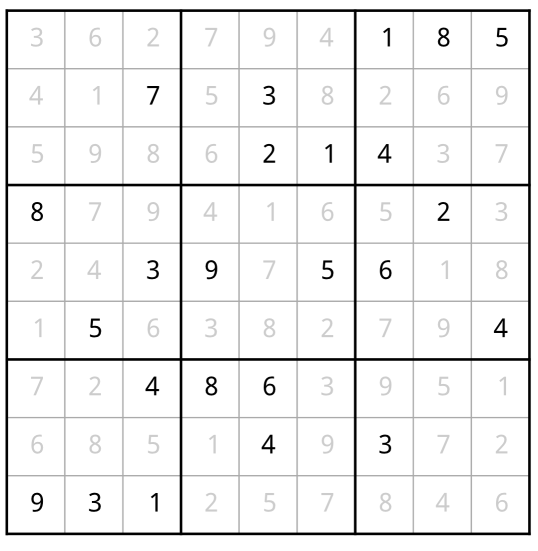

SATはブール論理を解くソルバーであり、各変数は`False`または`True`の2つの値しか取りません。数独のグリッドを表現するために、三次元配列 `bools` を使用します。その0番目の軸は数独グリッドの行、1番目の軸は列、2番目の軸は各セルの候補数字に対応します。例えば、最終的な解で `bools[4, 1, 3]` に対応するブール変数が真である場合、それは数独グリッドの5行目・2列目の値が4であることを意味します。なお、数独のゲームでは行・列・数字は1から始まりますが、プログラム内の配列のインデックスは0から始まることに注意してください。

以下の `bools` 配列には、SATソルバーで使用するブール変数の番号が保存されています。なお、SATのブール変数の番号は1から始まります。

In [10]:
import numpy as np
bools = np.arange(1, 9 * 9 * 9 + 1).reshape(9, 9, 9)

数独の制約条件に基づくと、以下のルールが成り立ちます：

1. **各セルには1つの数字のみを記入可能**  
   すなわち、`bools` の第2軸（数字の候補）のブール変数のうち、各セルにつき1つだけが `True` となる。

2. **各行に同じ数字は1つだけ存在可能**  
   `bools` の第1軸（列）の中で、各行において同じ数字のブール変数が `True` になるのは1つだけ。  例えば、`bools[0, :, 2]` は1行目の各セルにおける「数字3」のブール変数を表すが、1行には必ず1つの「3」しか存在できないため、この配列内で `True` になるのは1つだけ。

3. **各列に同じ数字は1つだけ存在可能**  
   `bools` の第0軸（行）の中で、各列において同じ数字のブール変数が `True` になるのは1つだけ。

4. **各ブロックに同じ数字は1つだけ存在可能**  
   これについてはやや複雑で、`bools` のインデックスを適切に調整する必要があるため、後ほど詳しく説明する。

数独の制約は、「ブール変数を異なるグループに分け、それぞれのグループ内で `True` になる変数が1つだけになるようにする」こと。では、SAT（充足可能性問題）を使って、この「グループ内で1つだけが `True`」という制約をどのように表現するかを見ていきます。

SATはCNFを使用し、各式はブール変数を「OR（論理和 `|`）」でつなぎ、式同士を「AND（論理積 `&`）」で接続します。我々が必要とするのは、「あるグループ内のブール変数のうち1つだけが `True`」という論理式です。

例えば、ブール変数 `A`、`B`、`C` の3つの変数について、この制約を満たすには以下の2つの論理式を組み合わせます：

1. **少なくとも1つは `True` であること**: （A、B、Cのいずれかが `True` であること）
   $$
   A | B | C
   $$
   

2. **2つ以上の変数が `True` にならないこと**  
   $$
   \neg(A \& B) \& \neg(A \& C) \& \neg(B \& C)
   $$
   これは、「任意の2つの変数が同時に `True` にならない」ことを意味します。

   この条件は、**ド・モルガンの法則** を適用すると次のように変形できます：

   $$
   (\neg A | \neg B) \& (\neg A | \neg C) \& (\neg B | \neg C)
   $$

   つまり、次のSATの論理式を得ます：
   $$
   (A | B | C) \& (\neg A | \neg B) \& (\neg A | \neg C) \& (\neg B | \neg C)
   $$

上記の条件を数独の各制約に適用するには、N個の要素から2つの要素をすべての組み合わせで選び出す必要があります。これは Python の `itertools.combinations` を用いて実装できます。

以下の `get_conditions()` 関数は、`bools` の最終軸にあるすべてのブール変数のうち、「1つだけが `True` になる」ことを保証するSATの制約を生成します。

❶ **N個の要素から2つの要素を選ぶすべての組み合わせを作成**  
   → 2次元配列 `index` を作り、形状 `(N * (N-1) / 2, 2)` のペアを格納。

❷ **最初の条件（少なくとも1つが `True`）を表す論理式を生成**  
   → 各グループの論理変数の番号をORでつなぐ。

❸ **2つ以上の変数が `True` にならない制約を生成**  
   → 各組み合わせに対して、`(~A | ~B)` の形の制約を作成。

こうして、数独の制約を満たすSATの論理式を構築できます。

In [14]:
from itertools import combinations

def get_conditions(bools):
    conditions = []
    n = bools.shape[-1]
    index = np.array(list(combinations(range(n), 2)))  # ❶
    # 最終軸をグループ化
    # 条件1: 各グループで1つだけが真である
    conditions.extend(bools.reshape(-1, n).tolist())  # ❷
    # 条件2: 各グループ内で2つの値が同時に真にならない
    conditions.extend((-bools[..., index].reshape(-1, 2)).tolist())  # ❸
    return conditions

以下は、1、2、3 と 4、5、6 の 2 つの論理変数グループに対する演算結果です。

In [15]:
get_conditions(np.array([[1, 2, 3], [4, 5, 6]]))

[[1, 2, 3],
 [4, 5, 6],
 [-1, -2],
 [-1, -3],
 [-2, -3],
 [-4, -5],
 [-4, -6],
 [-5, -6]]

以下では、`get_conditions()` を使用して数独の最初の3つの制約条件を計算します。これは最終軸に対してのみ演算を行うため、「各行の数字が重複しない」と「各列の数字が重複しない」という2つの条件については、対応する軸を最終軸に入れ替える必要があります。

In [16]:
c1 = get_conditions(bools)  # 各セルには1～9のうち1つの数字のみを取る  
c2 = get_conditions(np.swapaxes(bools, 1, 2))  # 各行で同じ数字は重複しない  
c3 = get_conditions(np.swapaxes(bools, 0, 2))  # 各列で同じ数字は重複しない  

制約条件4については、各ブロックのブール変数を最終軸に入れ替える必要があります。これには、`reshape()` と `swapaxes()` を交互に使用します。最後に、`c1`、`c2`、`c3`、`c4` を連結してリスト `conditions` を作成すると、数独ゲームのすべての制約条件を満たすSATの論理式が得られます。

In [17]:
tmp = np.swapaxes(bools.reshape(3, 3, 3, 3, 9), 1, 2).reshape(9, 9, 9)  
c4 = get_conditions(np.swapaxes(tmp, 1, 2))  # 各ブロック内で同じ数字は重複しない  

conditions = c1 + c2 + c3 + c4  

最後に、`CoSAT` を使用して数独ゲームを解きます。  

❶ `solve()` メソッドはリストを返すため、まずそれを `(9, 9, 9)` の形状に復元します。  

❷ 次に、その配列の最終軸で `1` に対応するインデックスを見つけ、実際に記入する数字はそのインデックスに `1` を加えたものになります。  

プログラムの出力を注意深く観察し、数独の制約条件を満たしているか分析してください。

In [18]:
def format_solution(solution):
    solution = np.array(solution).reshape(9, 9, 9)  # ❶
    return (np.where(solution > 0)[2] + 1).reshape(9, 9)  # ❷

sat = Solver()
sat.append_formula(conditions)
print(sat.solve())
solution = sat.get_model()
format_solution(solution)

True


array([[2, 4, 6, 1, 3, 5, 8, 7, 9],
       [1, 3, 5, 7, 8, 9, 2, 4, 6],
       [8, 7, 9, 2, 4, 6, 1, 3, 5],
       [5, 6, 3, 4, 1, 2, 7, 9, 8],
       [4, 1, 2, 9, 7, 8, 5, 6, 3],
       [7, 9, 8, 5, 6, 3, 4, 1, 2],
       [6, 5, 4, 3, 2, 1, 9, 8, 7],
       [3, 2, 1, 8, 9, 7, 6, 5, 4],
       [9, 8, 7, 6, 5, 4, 3, 2, 1]], dtype=int64)

以下では、`conditions` を使用して実際の数独ゲームを解きます。ゲームの初期状態は `sudoku_str` によって指定され、`0` は数字を記入する必要がある空白セルを表します。  

❶ 初期状態の各非0の数字に対して、それに対応するブール変数が真であるというブール式を作成し、`conditions2` を得ます。  

❷ このゲームの解は、`conditions` と `conditions2` の両方の条件を満たします。

In [19]:
sudoku_str = """
000000185
007030000
000021400
800000020
003905600
050000004
004860000
000040300
931000000"""

sudoku = np.array([[int(x) for x in line]
                   for line in sudoku_str.strip().split()])
r, c = np.where(sudoku != 0)
v = sudoku[r, c] - 1

conditions2 = [[int(x)] for x in bools[r, c, v]]  # ❶
sat = Solver()
sat.append_formula(conditions + conditions2)  # ❷
sat.solve()
solution = sat.get_model()
format_solution(solution)

array([[3, 6, 2, 7, 9, 4, 1, 8, 5],
       [4, 1, 7, 5, 3, 8, 2, 6, 9],
       [5, 9, 8, 6, 2, 1, 4, 3, 7],
       [8, 7, 9, 4, 1, 6, 5, 2, 3],
       [2, 4, 3, 9, 7, 5, 6, 1, 8],
       [1, 5, 6, 3, 8, 2, 7, 9, 4],
       [7, 2, 4, 8, 6, 3, 9, 5, 1],
       [6, 8, 5, 1, 4, 9, 3, 7, 2],
       [9, 3, 1, 2, 5, 7, 8, 4, 6]], dtype=int64)

`conditions2` の各 OR 式には1つのブール変数しか含まれていないことに注目してください。このような単純な式には、`assumptions` パラメータを使って仮定条件を追加できます。この方法では、`conditions` の中の節だけを `Solver` に追加し、既知の真であるブール変数のリストを `solver()` メソッドの `assumptions` パラメータに渡します。`assumptions` を使用する利点の一つは、解決が完了した後、すべての仮定条件がクリアされることです。そのため、同じ `sat` オブジェクトを繰り返し使用して複数の数独ゲームを解くことができます。

In [25]:
sat = Solver()
sat.append_formula(conditions)
sat.solve(assumptions=bools[r, c, v].tolist())
solution = sat.get_model()
format_solution(solution)

array([[3, 6, 2, 7, 9, 4, 1, 8, 5],
       [4, 1, 7, 5, 3, 8, 2, 6, 9],
       [5, 9, 8, 6, 2, 1, 4, 3, 7],
       [8, 7, 9, 4, 1, 6, 5, 2, 3],
       [2, 4, 3, 9, 7, 5, 6, 1, 8],
       [1, 5, 6, 3, 8, 2, 7, 9, 4],
       [7, 2, 4, 8, 6, 3, 9, 5, 1],
       [6, 8, 5, 1, 4, 9, 3, 7, 2],
       [9, 3, 1, 2, 5, 7, 8, 4, 6]], dtype=int64)